# Introdução

Esse caderno tem por objetivo a criação de um modelo básico de treinamento, utilizando o classificador [RandomForest](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html), que faça a predição de homologação de arquivamentos de procedimentos enviados à 1A.CAM do MPF.

Esse modelo usará apenas os metadados dos procedimentos, sem fazer nenhum processamento textual.

O objetivo desse modelo é servir como um *baseline* de comparações para implementações futuras.


**Nota**: os dados desse modelo foram recuperados de procedimentos que tiveram suas deliberações realizadas após o dia 02/07/2018, data em que a nova composição tomou posse na 1A.CAM.

# Carga de dados e pré-processamento

Vamos fazer a carga dos dados e fazer um pré-processamento tradicional (remoção de atributos que não interessam, criação de variáveis categóricas etc.)

In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
from sklearn.ensemble import RandomForestClassifier
import numpy as np
import pandas as pd

from sklearn import metrics

In [3]:
PATH = "../data/"
df_original = pd.read_json(f'{PATH}/1A.CAM.homologacao-arquivamento.json')

In [4]:
len(df_original)

6216

In [5]:
df_original.columns

Index(['areaAtuacao', 'classe', 'dataAutuacao', 'dataEntrada', 'homologado',
       'id', 'identificadorPecaPromocao', 'itemCnmp', 'membroResponsavel',
       'municipio', 'prioritario', 'procedimento', 'quantidadeConversoes',
       'quantidadeProvidencias', 'textosProvidencias', 'urgente'],
      dtype='object')

In [6]:
df_original.describe()

,areaAtuacao,classe,homologado,id,identificadorPecaPromocao,itemCnmp,membroResponsavel,municipio,prioritario,quantidadeConversoes,quantidadeProvidencias,urgente
count,6.216000e+03,6216.000000,6216.000000,6.216000e+03,5.416000e+03,6.216000e+03,5416.000000,6216.000000,6216.000000,6216.000000,6216.000000,6216.000000
mean,3.240209e+02,2.530727,0.984878,6.728554e+07,7.826234e+07,2.407387e+04,38441.630908,2892.811776,0.006757,2.038288,7.249839,0.006918
std,2.536836e+04,0.923644,0.122049,1.323833e+07,6.341954e+06,2.100612e+05,34276.472876,1671.129519,0.081928,1.398246,8.758556,0.082891
min,1.000000e+00,1.000000,0.000000,2.842880e+06,5.580442e+07,2.000000e+00,752.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000e+00,2.000000,1.000000,6.400090e+07,7.311781e+07,1.521000e+03,13674.000000,1388.750000,0.000000,1.000000,3.000000,0.000000
50%,2.000000e+00,3.000000,1.000000,7.000453e+07,7.810596e+07,1.581500e+03,24990.000000,3078.000000,0.000000,2.000000,5.000000,0.000000
75%,2.000000e+00,3.000000,1.000000,7.543822e+07,8.461602e+07,1.893000e+03,53327.000000,4321.000000,0.000000,3.000000,9.000000,0.000000
max,2.000085e+06,61.000000,1.000000,8.756619e+07,8.810570e+07,2.007548e+06,127563.000000,5768.000000,1.000000,13.000000,161.000000,1.000000


In [7]:
len(df_original[df_original.identificadorPecaPromocao.isnull()])

800

In [8]:
df_work = df_original.copy()

In [9]:
# elementos com peça de promoção de arquivamento nulos não nos interessam
#df_work.dropna(subset=['identificadorPecaPromocao'], inplace=True)
#df_work.reset_index(drop=True, inplace=True)

In [10]:
#len(df_work[df_work.identificadorPecaPromocao.isnull()])

0

In [9]:
# nessa primeira passada, essas colunas não nos interessam
removed_columns = ['id', 'procedimento', 'textosProvidencias', 'identificadorPecaPromocao']
df_work = df_work.drop(columns=removed_columns)
df_work.sample(10)

,areaAtuacao,classe,dataAutuacao,dataEntrada,homologado,itemCnmp,membroResponsavel,municipio,prioritario,quantidadeConversoes,quantidadeProvidencias,urgente
841,2,3,06-02-2015,18-06-2018,1,1076,127505.0,145,0,3,5,0
6118,2,3,07-02-2013,08-06-2015,1,1507,53256.0,2972,0,1,10,0
2969,2,2,21-02-2017,20-06-2017,1,1893,127555.0,5108,0,1,2,0
4337,5,3,05-10-2015,01-12-2016,1,763,64246.0,1301,0,3,3,0
2752,2,3,27-12-2012,18-07-2017,1,3066,116509.0,3056,0,4,29,0
2683,3,2,26-09-2016,01-08-2017,1,3049,64325.0,3042,0,2,4,0
998,2,3,22-03-2017,07-06-2018,1,1102,53289.0,4235,0,1,5,0
5766,2,2,17-07-2015,12-02-2016,1,1503,NaN,2785,0,1,4,0
5557,2,2,06-08-2015,06-04-2016,1,1523,11319.0,3455,0,2,2,0
4577,2,3,13-03-2015,14-11-2016,1,1523,87455.0,404,0,4,8,0


In [10]:
df_work.describe()

,areaAtuacao,classe,homologado,itemCnmp,membroResponsavel,municipio,prioritario,quantidadeConversoes,quantidadeProvidencias,urgente
count,6.216000e+03,6216.000000,6216.000000,6.216000e+03,5416.000000,6216.000000,6216.000000,6216.000000,6216.000000,6216.000000
mean,3.240209e+02,2.530727,0.984878,2.407387e+04,38441.630908,2892.811776,0.006757,2.038288,7.249839,0.006918
std,2.536836e+04,0.923644,0.122049,2.100612e+05,34276.472876,1671.129519,0.081928,1.398246,8.758556,0.082891
min,1.000000e+00,1.000000,0.000000,2.000000e+00,752.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000e+00,2.000000,1.000000,1.521000e+03,13674.000000,1388.750000,0.000000,1.000000,3.000000,0.000000
50%,2.000000e+00,3.000000,1.000000,1.581500e+03,24990.000000,3078.000000,0.000000,2.000000,5.000000,0.000000
75%,2.000000e+00,3.000000,1.000000,1.893000e+03,53327.000000,4321.000000,0.000000,3.000000,9.000000,0.000000
max,2.000085e+06,61.000000,1.000000,2.007548e+06,127563.000000,5768.000000,1.000000,13.000000,161.000000,1.000000


In [11]:
# tratando os nulos
df_work.fillna(0, inplace=True)

In [19]:
len(df_work[df_work['homologado'] == 1]),len(df_work[df_work['homologado'] == 0])

(6122, 94)

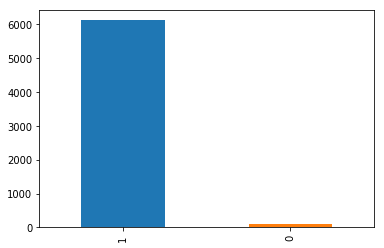

In [20]:
df_work['homologado'].value_counts().plot.bar()

### Classes desbalanceadas!!!

Conforme podemos ver acima, as classes desse problema são altamente desbalanceadas - apenas 1.46% do conjunto de dados representam procedimentos que não foram homologados.

Isso, muito provavelmente, causará problemas no treino do modelo. Mas, inicialmente, vamos ignorar isso e seguir com o nosso treino.

In [21]:
# conversão para datas
df_work['dataAutuacao'] = pd.to_datetime(df_work['dataAutuacao'],infer_datetime_format=True)
df_work['dataEntrada'] = pd.to_datetime(df_work['dataEntrada'],infer_datetime_format=True)

In [22]:
# vamos criar uma variável derivada, representando a quantidade de dias desde a autuação até a entrada
df_work['diasTranscorridos'] = 0
for index in range(len(df_work)):
    df_work.loc[index, 'diasTranscorridos'] =  np.abs((df_work.loc[index, 'dataEntrada'] - df_work.loc[index, 'dataAutuacao']).days)

In [23]:
df_work.sample(10)

,areaAtuacao,classe,dataAutuacao,dataEntrada,homologado,itemCnmp,membroResponsavel,municipio,prioritario,quantidadeConversoes,quantidadeProvidencias,urgente,diasTranscorridos
6147,2,2,2015-03-19,2015-08-13,1,63,64339.0,404,0,1,1,0,147
1912,2,2,2017-06-13,2018-01-03,1,3147,12003.0,3327,0,2,2,0,204
4154,2,3,2015-03-18,2017-01-24,1,1580,0.0,4766,0,3,9,0,678
1878,2,3,2017-09-11,2018-03-12,1,2830,64208.0,1387,0,1,1,0,182
1483,2,2,2018-02-20,2018-04-24,1,1542,64268.0,5115,0,1,2,0,63
2379,2,3,2016-06-05,2017-09-26,1,3119,64203.0,948,0,3,5,0,478
400,3,3,2011-04-26,2018-07-17,1,1503,23719.0,2031,0,6,26,0,2639
6193,2,3,2014-07-28,2015-08-04,1,1559,0.0,3983,0,0,5,0,372
4993,2,2,2016-04-22,2016-06-30,1,3047,3591.0,4255,0,1,5,0,69
6063,2,2,2015-01-07,2015-10-07,1,2286,87500.0,1466,0,1,1,0,273


In [24]:
removed_columns = ['homologado', 'dataEntrada', 'dataAutuacao']
features = [c for c in df_work.columns if c not in removed_columns]

model = RandomForestClassifier(random_state=42)
model.fit(df_work[features], df_work['homologado'])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [25]:
model.score(df_work[features], df_work['homologado'])

0.9987129987129987

In [26]:
from sklearn.model_selection import train_test_split

train, valid = train_test_split(df_work, random_state=42)
train.shape, valid.shape

((4662, 13), (1554, 13))

In [27]:
model.fit(train[features], train['homologado'])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [28]:
train_preds = model.predict(train[features])
valid_preds = model.predict(valid[features])

In [29]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def print_score():
    print('Accuracy score:', accuracy_score(train['homologado'], train_preds), accuracy_score(valid['homologado'], valid_preds))
    print('Precision score: ', format(precision_score(valid['homologado'], valid_preds)))
    print('Recall score: ', format(recall_score(valid['homologado'], valid_preds)))
    print('F1 score: ', format(f1_score(valid['homologado'], valid_preds)))

print_score()

Accuracy score: 0.9984984984984985 0.9826254826254827
Precision score:  0.9826254826254827
Recall score:  1.0
F1 score:  0.991236611489776


### Primeira avaliação

Embora não tenha ocorrido overfitting no treinamento e o *score* final tenha sido alto, cabe utilizar uma outra medida para assegurar a qualidade do modelo. Vamos utilizar a ** *matriz de confusão* **.



In [30]:
from sklearn.metrics import confusion_matrix

confusion_matrix(valid['homologado'], valid_preds)

array([[   0,   27],
       [   0, 1527]], dtype=int64)

In [31]:
confusion_matrix(valid['homologado'], valid_preds).ravel()

array([   0,   27,    0, 1527], dtype=int64)

In [26]:
len(valid[valid['homologado']==1]), len(valid[valid['homologado']==0])

(1332, 22)

Ao utilizar o ravel(), temos uma saída do tipo (tn, fp, fn, tp). De onde vemos que:


- tivemos 1 tn - *true negative*; ou seja, o modelo acertou **apenas um** dos que não tiveram o arquivamento homologado;
- tivemos 27 fp - *false positive*; 21 que não tiveram o arquivamento homologado e o modelo classificou como homologado;
- tivemos 0 fn - *false negative*; foram homologados e o modelo marcou como não homologados;
- tivemos 1527 tp - *true positive*; foram homologados e o modelo marcou corretamente.

Logo, apesar da acurácia do modelo aparentar ser muito boa (98% no validation set), o **modelo não sabe lidar com os não arquivamentos** - não acertou nenhum dos que realmente não foram homologados. Ou seja dos 27 que não foram homologados, o modelo errou todos.

Fica claro que somente essas features não ajudam na descoberta - o texto da íntegra é, segundo a área negocial, realmente o mais importante.

Vamos continuar avaliando esse modelo.

## Feature importances

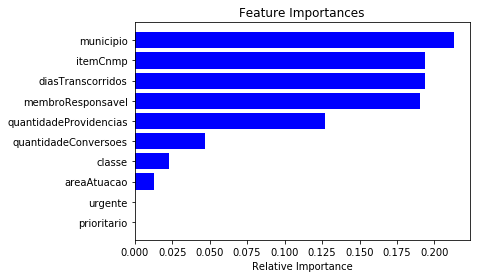

In [32]:
import matplotlib.pyplot as plt

def plot_fi(feature_importances, size=None):
    feature_importances = model.feature_importances_
    
    if not size:
        size = len(feature_importances)
    
    indices = np.argsort(feature_importances[0:size])
    
    plt.title('Feature Importances')
    plt.barh(range(size), feature_importances[indices], color='b', align='center')
    plt.yticks(range(size), [features[i] for i in indices if i < size])
    plt.xlabel('Relative Importance')
    plt.show()
    
plot_fi(model.feature_importances_)

O modelo está dando muita importância ao município que, considerando o bom senso e um pouco de domínio negocial, não faz sentido - o município não deveria interferir.

Lembrar: criar uma coluna para cada uma das listas de palavras-chaves, indicando ausência ou presença

In [33]:
# Vou retirar as colunas com poucas importância
removed_columns = ['homologado', 'dataEntrada', 'dataAutuacao', 'urgente', 'prioritario']
features = [c for c in df_work.columns if c not in removed_columns]

model = RandomForestClassifier(random_state=42)

model.fit(train[features], train['homologado'])

train_preds = model.predict(train[features])
valid_preds = model.predict(valid[features])

print_score()

Accuracy score: 0.9982839982839983 0.9826254826254827
Precision score:  0.9826254826254827
Recall score:  1.0
F1 score:  0.991236611489776


In [34]:
confusion_matrix(valid['homologado'], valid_preds).ravel()

array([   0,   27,    0, 1527], dtype=int64)

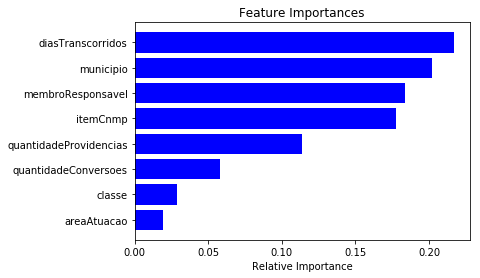

In [35]:
plot_fi(model.feature_importances_)

Com as novas features, retirando a urgente e a prioritário, não houve melhorias.

Vou retirar a coluna município, pois, ao meu ver, ela não nos parece adequada - e o modelo continua dando muita importância a ela.

In [36]:
removed_columns.append('municipio')
removed_columns

features = [c for c in df_work.columns if c not in removed_columns]

model.fit(train[features], train['homologado'])

train_preds = model.predict(train[features])
valid_preds = model.predict(valid[features])

print_score()

Accuracy score: 0.9978549978549979 0.9826254826254827
Precision score:  0.9826254826254827
Recall score:  1.0
F1 score:  0.991236611489776


In [37]:
confusion_matrix(valid['homologado'], valid_preds).ravel()

array([   0,   27,    0, 1527], dtype=int64)

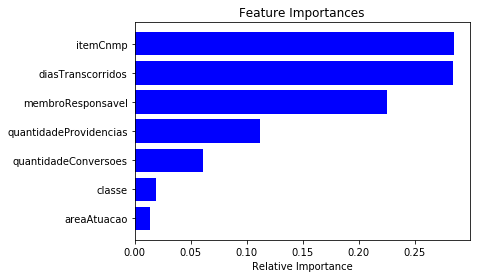

In [38]:
plot_fi(model.feature_importances_)

Ao retirar a coluna município, nada mudou.

Vamos criar um modelo ainda mais simples, apenas com as features cuja importância seja maior que 5%.

In [39]:
model = RandomForestClassifier(random_state=42)

important_features = ['membroResponsavel', 'diasTranscorridos', 'itemCnmp', 'quantidadeProvidencias', 'quantidadeConversoes']
model.fit(train[important_features], train['homologado'])

train_preds = model.predict(train[important_features])
valid_preds = model.predict(valid[important_features])

print_score()

Accuracy score: 0.9982839982839983 0.9826254826254827
Precision score:  0.9826254826254827
Recall score:  1.0
F1 score:  0.991236611489776


In [40]:
confusion_matrix(valid['homologado'], valid_preds).ravel()

array([   0,   27,    0, 1527], dtype=int64)

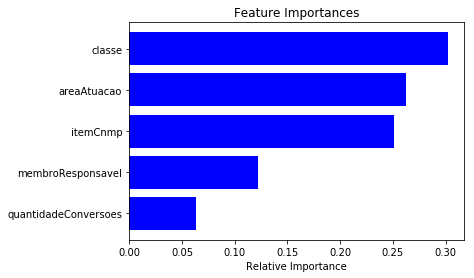

In [41]:
plot_fi(model.feature_importances_)

Somente com as features importantes acima, o desempenho se manteve. 

Interessante notar que a variável diasTranscorridos desapereceu da lista de importâncias.

Vamos fazer mais um teste, apenas com as top-3 features

In [42]:
important_features = ['classe', 'areaAtuacao', 'itemCnmp']

model = RandomForestClassifier(random_state=42)
model.fit(train[important_features], train['homologado'])

train_preds = model.predict(train[important_features])
valid_preds = model.predict(valid[important_features])

print_score()

Accuracy score: 0.9877734877734877 0.98005148005148
Precision score:  0.9825806451612903
Recall score:  0.9973804846103471
F1 score:  0.9899252518687033


In [43]:
confusion_matrix(valid['homologado'], valid_preds).ravel()

array([   0,   27,    4, 1523], dtype=int64)

Com o modelo mais simples, a acurácia caiu e apareceram false negatives.. 

Fica claro que não sabe lidar com os não homologados.

Vamos passar a considerar o texto das providências.

## Considerando as providências realizadas

In [46]:
df_work = df_original.copy()

df_work['dataAutuacao'] = pd.to_datetime(df_work['dataAutuacao'],infer_datetime_format=True)
df_work['dataEntrada'] = pd.to_datetime(df_work['dataEntrada'],infer_datetime_format=True)

df_work['diasTranscorridos'] = 0
for index in range(len(df_work)):
    df_work.loc[index, 'diasTranscorridos'] =  np.abs((df_work.loc[index, 'dataEntrada'] - df_work.loc[index, 'dataAutuacao']).days)

removed_columns = ['id', 'procedimento', 'identificadorPecaPromocao', 'prioritario', 'urgente', 'dataAutuacao', 'dataEntrada']
df_work = df_work.drop(columns=removed_columns)
df_work.fillna(0, inplace=True)

    
df_work.sample(10)

,areaAtuacao,classe,homologado,itemCnmp,membroResponsavel,municipio,quantidadeConversoes,quantidadeProvidencias,textosProvidencias,diasTranscorridos
4489,5,3,1,3071,20038.0,1169,2,4,"Converta-se em Inquérito Civil(IC).,Certifica ...",749
3675,2,3,1,1556,0.0,5115,3,5,"Converta-se em Inquérito Civil(IC).,Oficie-se,...",380
3327,2,3,1,1503,31498.0,3671,3,8,"Análise do arquivamento,Converta-se em Inquéri...",492
3619,2,2,1,1514,25768.0,5459,2,2,Prorroga-se o prazo de finalização do Procedim...,377
85,2,3,1,1567,64202.0,5026,5,14,"Converta-se em Inquérito Civil(IC).,Prorroga-s...",1410
2317,2,2,1,1753,31555.0,1810,1,1,Converta-se em Procedimento Preparatório(PP).,9
2219,2,2,1,1811,53295.0,2919,1,2,"Analisar Arquivamento,Converta-se em Procedime...",505
1462,2,2,1,1547,87528.0,2611,2,5,"Oficie-se,Prorroga-se o prazo de finalização d...",339
4432,2,3,1,1731,53252.0,1169,3,13,"Converta-se em Inquérito Civil(IC).,Oficie-se,...",547
872,2,3,1,1514,12363.0,4387,4,14,"Despacho Simplificado,Converta-se em Inquérito...",680


In [47]:
df_work.describe()

,areaAtuacao,classe,homologado,itemCnmp,membroResponsavel,municipio,quantidadeConversoes,quantidadeProvidencias,diasTranscorridos
count,6.216000e+03,6216.000000,6216.000000,6.216000e+03,6216.000000,6216.000000,6216.000000,6216.000000,6216.000000
mean,3.240209e+02,2.530727,0.984878,2.407387e+04,33494.188063,2892.811776,2.038288,7.249839,573.746139
std,2.536836e+04,0.923644,0.122049,2.100612e+05,34487.428708,1671.129519,1.398246,8.758556,603.339753
min,1.000000e+00,1.000000,0.000000,2.000000e+00,0.000000,1.000000,0.000000,0.000000,0.000000
25%,2.000000e+00,2.000000,1.000000,1.521000e+03,8592.000000,1388.750000,1.000000,3.000000,176.750000
50%,2.000000e+00,3.000000,1.000000,1.581500e+03,21293.000000,3078.000000,2.000000,5.000000,361.000000
75%,2.000000e+00,3.000000,1.000000,1.893000e+03,53296.000000,4321.000000,3.000000,9.000000,760.000000
max,2.000085e+06,61.000000,1.000000,2.007548e+06,127563.000000,5768.000000,13.000000,161.000000,5879.000000


In [48]:
listaProvidencias = []
for index in range(len(df_work)):
    for s in str(df_work['textosProvidencias'][index]).strip().lower().split(','):
        listaProvidencias.append(s)

listaProvidencias = set(listaProvidencias)
listaProvidencias.remove('análise do arquivamento')
listaProvidencias.remove('analisar arquivamento')
listaProvidencias.remove('arquive-se na unidade.')

In [49]:
df_work = pd.concat([df_work, pd.get_dummies(sorted(list(listaProvidencias)), drop_first=True)], axis=1)

In [50]:
for index in range(len(df_work)):
    for s in str(df_work.textosProvidencias[index]).strip().split(','):
        df_work.at[index, s.lower()] = 1

In [51]:
df_work.describe()

,areaAtuacao,classe,homologado,itemCnmp,membroResponsavel,municipio,quantidadeConversoes,quantidadeProvidencias,diasTranscorridos,analisar conflito de atribuição,...,recomende-se.,redistribua-se.,requisite-se perícia à ccr/mpf.,sobrestar no setor.,solicitar instauração de inquérito judicial,vistoria,analisar arquivamento,arquive-se na unidade.,,análise do arquivamento
count,6.216000e+03,6216.000000,6216.000000,6.216000e+03,6216.000000,6216.000000,6216.000000,6216.000000,6216.000000,109.000000,...,535.000000,599.000000,78.000000,811.000000,69.000000,77.000000,618.0,79.0,107.0,180.0
mean,3.240209e+02,2.530727,0.984878,2.407387e+04,33494.188063,2892.811776,2.038288,7.249839,573.746139,0.394495,...,0.878505,0.899833,0.141026,0.927250,0.028986,0.129870,1.0,1.0,1.0,1.0
std,2.536836e+04,0.923644,0.122049,2.100612e+05,34487.428708,1671.129519,1.398246,8.758556,603.339753,0.491000,...,0.327008,0.300473,0.350301,0.259885,0.168995,0.338365,0.0,0.0,0.0,0.0
min,1.000000e+00,1.000000,0.000000,2.000000e+00,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,1.0,1.0,1.0
25%,2.000000e+00,2.000000,1.000000,1.521000e+03,8592.000000,1388.750000,1.000000,3.000000,176.750000,0.000000,...,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.0,1.0,1.0,1.0
50%,2.000000e+00,3.000000,1.000000,1.581500e+03,21293.000000,3078.000000,2.000000,5.000000,361.000000,0.000000,...,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.0,1.0,1.0,1.0
75%,2.000000e+00,3.000000,1.000000,1.893000e+03,53296.000000,4321.000000,3.000000,9.000000,760.000000,1.000000,...,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.0,1.0,1.0,1.0
max,2.000085e+06,61.000000,1.000000,2.007548e+06,127563.000000,5768.000000,13.000000,161.000000,5879.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.0,1.0,1.0


In [52]:
df_work.head()

,areaAtuacao,classe,homologado,itemCnmp,membroResponsavel,municipio,quantidadeConversoes,quantidadeProvidencias,textosProvidencias,diasTranscorridos,...,recomende-se.,redistribua-se.,requisite-se perícia à ccr/mpf.,sobrestar no setor.,solicitar instauração de inquérito judicial,vistoria,analisar arquivamento,arquive-se na unidade.,,análise do arquivamento
0,2,3,1,3078,53306.0,2733,1,3,"Despacho Simplificado,Converta-se em Inquérito...",279,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
1,2,3,1,1515,4575.0,4108,5,17,"Encaminhe-se o auto.,Analisar Arquivamento,Ofi...",1947,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,NaN,NaN,NaN
2,2,3,1,1542,17795.0,5296,2,4,"Converta-se em Inquérito Civil(IC).,Oficie-se....",367,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
3,2,3,1,3058,5262.0,3573,3,9,"Converta-se em Inquérito Civil(IC).,Analisar A...",1030,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,NaN,NaN,NaN
4,2,3,1,1521,53306.0,2561,1,2,"Converta-se em Inquérito Civil(IC).,Cumpra-se.",552,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN


In [53]:
df_work.fillna(0, inplace=True)

In [54]:
removed_columns = ['homologado', 'textosProvidencias']
features = [c for c in df_work.columns if c not in removed_columns]

In [55]:
train, valid = train_test_split(df_work, random_state=42)

model = RandomForestClassifier(random_state=42)
model.fit(train[features], train['homologado'])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [56]:
train_preds = model.predict(train[features])
valid_preds = model.predict(valid[features])

print_score()

Accuracy score: 0.9982839982839983 0.9819819819819819
Precision score:  0.9826142949130715
Recall score:  0.9993451211525868
F1 score:  0.9909090909090911


In [57]:
confusion_matrix(valid['homologado'], valid_preds).ravel()

array([   0,   27,    1, 1526], dtype=int64)

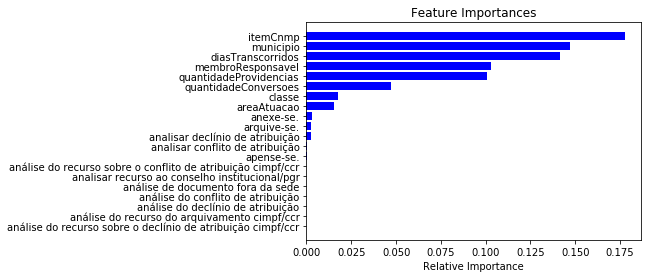

In [58]:
plot_fi(model.feature_importances_, 20)

O uso dos textos das providências não aumentou a precisão do modelo (e elas também não foram features importantes) - na verdade, piorou.

Vamos voltar ao modelo mais simples, sem os textos das providências e tentar melhorar os hiperparâmetros.

## Voltando ao modelo mais simples (sem considerar quais providências foram realizadas)

In [59]:
df_work = df_original.copy()

df_work['dataAutuacao'] = pd.to_datetime(df_work['dataAutuacao'],infer_datetime_format=True)
df_work['dataEntrada'] = pd.to_datetime(df_work['dataEntrada'],infer_datetime_format=True)

df_work['diasTranscorridos'] = 0
for index in range(len(df_work)):
    df_work.loc[index, 'diasTranscorridos'] =  np.abs((df_work.loc[index, 'dataEntrada'] - df_work.loc[index, 'dataAutuacao']).days)

removed_columns = ['id', 'procedimento', 'identificadorPecaPromocao', 'prioritario', 'urgente', 'dataAutuacao', 'dataEntrada']
df_work = df_work.drop(columns=removed_columns)
df_work.fillna(0, inplace=True)

    
df_work.sample(10)

,areaAtuacao,classe,homologado,itemCnmp,membroResponsavel,municipio,quantidadeConversoes,quantidadeProvidencias,textosProvidencias,diasTranscorridos
3942,2,3,1,3147,0.0,618,4,17,"Converta-se em Inquérito Civil(IC).,Certifica ...",1097
6027,2,2,1,1506,87457.0,2,1,2,"Analisar Arquivamento,Converta-se em Procedime...",230
5702,2,2,1,1521,27032.0,1214,2,5,"Oficie-se.,Prorroga-se o prazo de finalização ...",202
988,2,3,1,1521,53245.0,3689,5,33,"Despacho Simplificado,Encaminhe-se o auto.,Con...",1046
1642,2,2,1,3119,17209.0,4918,2,8,"Oficie-se.,Prorroga-se o prazo de finalização ...",283
51,2,2,1,57,23450.0,1996,3,7,"Despacho Simplificado,Oficie-se.,Prorroga-se o...",233
1758,2,3,1,3047,3653.0,1443,3,7,"Converta-se em Inquérito Civil(IC).,Oficie-se....",381
2135,2,3,1,1721,2663.0,3113,2,12,"Converta-se em Inquérito Civil(IC).,Junte-se.,...",392
5912,2,2,1,1654,23212.0,2211,0,3,"Sobrestar no setor.,Oficie-se.",133
596,2,3,1,2310,31446.0,2292,4,16,"Converta-se em Inquérito Civil(IC).,Sobrestar ...",1392


In [72]:
removed_columns = ['homologado', 'textosProvidencias']
features = [c for c in df_work.columns if c not in removed_columns]

train, valid = train_test_split(df_work, random_state=42)

In [75]:
model = RandomForestClassifier(random_state=42); model

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [76]:
model.fit(train[features], train['homologado'])

train_preds = model.predict(train[features])
valid_preds = model.predict(valid[features])

print_score()

Accuracy score: 0.9982839982839983 0.9826254826254827
Precision score:  0.9826254826254827
Recall score:  1.0
F1 score:  0.991236611489776


In [77]:
confusion_matrix(valid['homologado'], valid_preds).ravel()

array([   0,   27,    0, 1527], dtype=int64)

### Aumentando o número de árvores

In [78]:
model = RandomForestClassifier(random_state=42, n_estimators=100)
model.fit(train[features], train['homologado'])
confusion_matrix(valid['homologado'], valid_preds).ravel()
train_preds = model.predict(train[features])
valid_preds = model.predict(valid[features])

print_score()

Accuracy score: 1.0 0.9826254826254827
Precision score:  0.9826254826254827
Recall score:  1.0
F1 score:  0.991236611489776


In [79]:
confusion_matrix(valid['homologado'], valid_preds).ravel()

array([   0,   27,    0, 1527], dtype=int64)

In [80]:
model = RandomForestClassifier(random_state=42, n_estimators=1000)
model.fit(train[features], train['homologado'])
confusion_matrix(valid['homologado'], valid_preds).ravel()
train_preds = model.predict(train[features])
valid_preds = model.predict(valid[features])

print_score()

Accuracy score: 1.0 0.9826254826254827
Precision score:  0.9826254826254827
Recall score:  1.0
F1 score:  0.991236611489776


In [81]:
confusion_matrix(valid['homologado'], valid_preds).ravel()

array([   0,   27,    0, 1527], dtype=int64)

In [82]:
model = RandomForestClassifier(random_state=42, n_estimators=2000)
model.fit(train[features], train['homologado'])
confusion_matrix(valid['homologado'], valid_preds).ravel()
train_preds = model.predict(train[features])
valid_preds = model.predict(valid[features])

print_score()

Accuracy score: 1.0 0.9826254826254827
Precision score:  0.9826254826254827
Recall score:  1.0
F1 score:  0.991236611489776


In [83]:
confusion_matrix(valid['homologado'], valid_preds).ravel()

array([   0,   27,    0, 1527], dtype=int64)

Aumentar o número de árvores parece não melhorar a performance. Vamos para o número de features.

### Considerando o número de features

In [97]:
model = RandomForestClassifier(random_state=42); model

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [85]:
model.fit(train[features], train['homologado'])
confusion_matrix(valid['homologado'], valid_preds).ravel()
train_preds = model.predict(train[features])
valid_preds = model.predict(valid[features])

print_score()

Accuracy score: 0.9982839982839983 0.9826254826254827
Precision score:  0.9826254826254827
Recall score:  1.0
F1 score:  0.991236611489776


In [86]:
model = RandomForestClassifier(random_state=42, max_features='sqrt')
model.fit(train[features], train['homologado'])
confusion_matrix(valid['homologado'], valid_preds).ravel()
train_preds = model.predict(train[features])
valid_preds = model.predict(valid[features])

print_score()

Accuracy score: 0.9982839982839983 0.9826254826254827
Precision score:  0.9826254826254827
Recall score:  1.0
F1 score:  0.991236611489776


In [87]:
confusion_matrix(valid['homologado'], valid_preds).ravel()

array([   0,   27,    0, 1527], dtype=int64)

In [88]:
model = RandomForestClassifier(random_state=42, max_features='log2')
model.fit(train[features], train['homologado'])
confusion_matrix(valid['homologado'], valid_preds).ravel()
train_preds = model.predict(train[features])
valid_preds = model.predict(valid[features])

print_score()

Accuracy score: 0.9984984984984985 0.9819819819819819
Precision score:  0.9826142949130715
Recall score:  0.9993451211525868
F1 score:  0.9909090909090911


In [89]:
confusion_matrix(valid['homologado'], valid_preds).ravel()

array([   0,   27,    1, 1526], dtype=int64)

In [95]:
model = RandomForestClassifier(random_state=42, max_features=0.3)
model.fit(train[features], train['homologado'])
confusion_matrix(valid['homologado'], valid_preds).ravel()
train_preds = model.predict(train[features])
valid_preds = model.predict(valid[features])

print_score()

Accuracy score: 0.9982839982839983 0.9826254826254827
Precision score:  0.9826254826254827
Recall score:  1.0
F1 score:  0.991236611489776


In [96]:
confusion_matrix(valid['homologado'], valid_preds).ravel()

array([   0,   27,    0, 1527], dtype=int64)

O parâmetro max_features parece não melhorar a performance. Vamos para o min_samples_leaf.

### Checando o min_samples_leaf

In [98]:
model = RandomForestClassifier(random_state=42); model

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [99]:
model.fit(train[features], train['homologado'])
confusion_matrix(valid['homologado'], valid_preds).ravel()
train_preds = model.predict(train[features])
valid_preds = model.predict(valid[features])

print_score()

Accuracy score: 0.9982839982839983 0.9826254826254827
Precision score:  0.9826254826254827
Recall score:  1.0
F1 score:  0.991236611489776


In [100]:
model = RandomForestClassifier(random_state=42, min_samples_leaf=2)
model.fit(train[features], train['homologado'])
confusion_matrix(valid['homologado'], valid_preds).ravel()
train_preds = model.predict(train[features])
valid_preds = model.predict(valid[features])

print_score()

Accuracy score: 0.9877734877734877 0.9826254826254827
Precision score:  0.9826254826254827
Recall score:  1.0
F1 score:  0.991236611489776


In [101]:
confusion_matrix(valid['homologado'], valid_preds).ravel()

array([   0,   27,    0, 1527], dtype=int64)

In [102]:
model = RandomForestClassifier(random_state=42, min_samples_leaf=5)
model.fit(train[features], train['homologado'])
confusion_matrix(valid['homologado'], valid_preds).ravel()
train_preds = model.predict(train[features])
valid_preds = model.predict(valid[features])

print_score()

Accuracy score: 0.9856284856284856 0.9826254826254827
Precision score:  0.9826254826254827
Recall score:  1.0
F1 score:  0.991236611489776


In [103]:
model = RandomForestClassifier(random_state=42, min_samples_leaf=10)
model.fit(train[features], train['homologado'])
confusion_matrix(valid['homologado'], valid_preds).ravel()
train_preds = model.predict(train[features])
valid_preds = model.predict(valid[features])

print_score()

Accuracy score: 0.9856284856284856 0.9826254826254827
Precision score:  0.9826254826254827
Recall score:  1.0
F1 score:  0.991236611489776


In [106]:
confusion_matrix(valid['homologado'], valid_preds).ravel()

array([   0,   27,    0, 1527], dtype=int64)

Uma vez mais, não houve melhoria no modelo ao tentar modificar o min_samples_leaf.

Vamos tentar uma última coisa, que é lidar com o fato de as classes serem desbalanceadas.

## Lidando com as classes desbalanceadas

https://machinelearningmastery.com/tactics-to-combat-imbalanced-classes-in-your-machine-learning-dataset/